# Global Forecasting Models: Dependent multi-series forecasting (Multivariate forecasting)

[Univariate time series forecasting](../introduction-forecasting/introduction-forecasting.html) focuses on modeling a single time series as a linear or nonlinear function of its own past values (lags), using historical observations to predict future ones.

**Global forecasting** builds a single predictive model that considers all time series simultaneously. This approach seeks to learn the shared patterns that underlie the different series, helping to reduce the influence of noise present in individual time series. It is computationally efficient, easier to maintain, and often yields more robust generalization across series.

In **dependent multi-series forecasting** (also known as **multivariate time series forecasting**), all series are modeled jointly under the assumption that each series depends not only on its own past values, but also on the past values of the other series. The forecaster is expected to learn both the individual dynamics of each series and the relationships between them.

A typical example is the set of sensor readings (such as flow, temperature, and pressure) collected from an industrial machine like a compressor, where the variables influence each other over time.

<p style="text-align: center">
<img src="../img/forecaster_multivariate_train_matrix_diagram.png" style="width: 600px">
<br>
<font size="2.5"> <i>Internal Forecaster time series transformation to train a forecaster with multiple dependent time series.</i></font>
</p>

Since a separate training matrix is created for each series in the dataset, it is necessary to define the **target level** on which forecasting will be performed. To predict the next n steps, one model is trained for each forecast horizon step. In the example shown, the selected level is `Series 1`.

This approach corresponds to a [direct multi-step forecasting strategy](../introduction-forecasting/introduction-forecasting.html#direct-multi-step-forecasting), where each step is predicted independently using a separate model.

<p style="text-align: center">
<img src="../img/forecaster_multivariate_prediction_diagram.png" style="width: 600px">
<br>
<font size="2.5"> <i>Diagram of direct forecasting with multiple dependent time series.</i></font>
</p>

Using the <code>ForecasterDirectMultiVariate</code> class, it is possible to easily build machine learning models for **multivariate forecasting**.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<b>Why can only one series be predicted?</b>

Direct forecasting strategies face a <b>scalability challenge</b>.

To predict multiple time series and multiple time steps, you would need a <b>separate model for each series and each future time step</b>. For example, with 1,000 series and a forecast horizon of 24, this would require training 24,000 individual models, a computationally impractical approach.

That’s why the <code>ForecasterDirectMultiVariate</code> can <b>learn from multiple series</b>, but can only predict one series at a time.

<b>Looking for true multivariate with multiple series?</b>

Try our <a href="../user_guides/forecasting-with-deep-learning-rnn-lstm.html"><code>ForecasterRnn</code></a> class, which can handle <b>multivariate forecasting with multiple series</b> and multiple steps in a single deep learning model.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Skforecast offers additional approaches to create Global Forecasting Models:

<ul>
    <li>
    <a href="../user_guides/independent-multi-time-series-forecasting.html">Global Forecasting Models: Independent multi-series forecasting</a>
    </li>
    <li>
    <a href="../user_guides/multi-series-with-different-length-and-different_exog.html">Global Forecasting Models: Time series with different lengths and different exogenous variables</a>
    </li>
    <li>
    <a href="../user_guides/forecasting-with-deep-learning-rnn-lstm.html">Global Forecasting Models: Forecasting with Deep Learning</a>
    </li>
</ul>


To learn more about global forecasting models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html">Global Forecasting Models: Multi-series forecasting with Python and skforecast</a>
    </li>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py59-scalable-forecasting-models.html">Scalable Forecasting: Modeling thousand time series with a single global model</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py53-global-forecasting-models">Global Forecasting Models: Comparative Analysis of Single and Multi-Series Forecasting Modeling</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py54-forecasting-with-deep-learning">Forecasting with Deep Learning</a>
    </li>
</ul>

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.model_selection import (
    OneStepAheadFold,
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    grid_search_forecaster_multiseries,
    random_search_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.plot import set_dark_theme

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name="air_quality_valencia_no_missing")

╭──────────────────────── air_quality_valencia_no_missing ─────────────────────────╮
│ Description:                                                                     │
│ Hourly measures of several air chemical pollutant at Valencia city (Avd.         │
│ Francia) from 2019-01-01 to 20213-12-31. Including the following variables:      │
│ pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),   │
│ O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³). Missing values have     │
│ been imputed using linear interpolation.                                         │
│                                                                                  │
│ Source:                                                                          │
│ Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València - │
│ Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-           │
│ historicos.                                                                      │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/air_quality_valencia_no_missing.csv                           │
│                                                                                  │
│ Shape: 43824 rows x 10 columns                                                   │
╰──────────────────────────────────────────────────────────────────────────────────╯

In [3]:
# Aggregate at daily frequency to reduce dimensions
# ==============================================================================
data = data.resample('D').mean()
print("Shape: ", data.shape)
data.head()

Shape:  (1826, 10)


,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01,6.000000,0.141667,17.375000,37.250000,21.458333,63.458333,20.291667,0.416667,207.416667,17.208333
2019-01-02,6.041667,0.170833,23.458333,49.333333,26.416667,85.041667,11.708333,0.579167,225.375000,17.375000
2019-01-03,5.916667,0.216667,41.291667,53.250000,36.166667,116.333333,9.833333,0.500000,211.833333,21.625000
2019-01-04,5.458333,0.204167,21.208333,45.750000,32.208333,77.958333,15.166667,0.675000,199.583333,22.166667
2019-01-05,4.541667,0.191667,10.291667,36.375000,32.875000,51.833333,21.083333,0.875000,254.208333,24.916667


In [4]:
# Split data into train-val-test
# ==============================================================================
end_train = '2023-05-31 23:59:59'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  "
    f"(n={len(data_test)})"
)

Train dates : 2019-01-01 00:00:00 --- 2023-05-31 00:00:00  (n=1612)
Test dates  : 2023-06-01 00:00:00 --- 2023-12-31 00:00:00  (n=214)


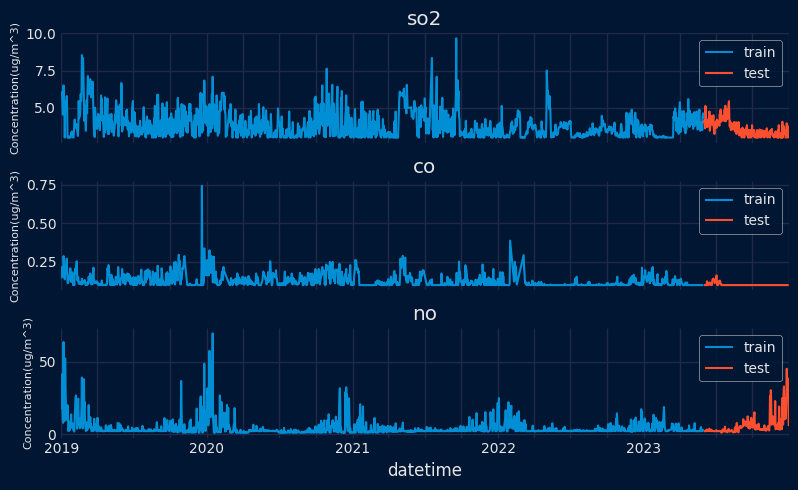

In [5]:
# Plot time series
# ==============================================================================
set_dark_theme()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 5), sharex=True)
for i, col in enumerate(data.columns[:3]):
    data_train[col].plot(ax=axes[i], label='train')
    data_test[col].plot(ax=axes[i], label='test')
    axes[i].set_ylabel('Concentration(ug/m^3)', fontsize=8)
    axes[i].set_title(col)
    axes[i].legend(loc='upper right')

fig.tight_layout()
plt.show();

## Train and predict ForecasterDirectMultiVariate

When initializing the forecaster, the series (`level`) to be predicted and the maximum number of `steps` must be indicated since a different model will be created for each step.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

<code>ForecasterDirectMultiVariate</code> includes the <code>n_jobs</code> argument, allowing <b>multi-process parallelization</b> to train regressors for all steps simultaneously, significantly reducing training time.

Its effectiveness depends on factors like the regressor type, the number of model fits to perform, and the volume of data. When <code>n_jobs</code> is set to <code>'auto'</code>, the level of parallelization is automatically determined using heuristic rules designed to select the most efficient configuration for each scenario.

For more information, see the guide <a href="../faq/parallelization-skforecast.html">Parallelization in skforecast</a>.

</div>

In [6]:
# Create and fit forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 steps              = 7,
                 lags               = 7,
                 window_features    = RollingFeatures(stats=['mean'], window_sizes=[7]),
                 transformer_series = None,
                 transformer_exog   = None
             )

forecaster.fit(series=data_train)
forecaster

============================ 
ForecasterDirectMultiVariate 
============================ 
Regressor: LGBMRegressor 
Target series (level): co 
Lags: [1 2 3 4 5 6 7] 
Window features: ['roll_mean_7'] 
Window size: 7 
Maximum steps to predict: 7 
Multivariate series: so2, co, no, no2, pm10, nox, o3, veloc., direc., pm2.5 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2023-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-11-24 21:56:41 
Last fit date: 2025-11-24 21:56:44 
Skforecast version: 0.19.0 
Python version: 3.13.9 
Forecaster id: None

When predicting, the value of `steps` must be less than or equal to the value of steps defined when initializing the forecaster. Starts at 1.

+ If `int` only steps within the range of 1 to int are predicted.

+ If `list` of `int`. Only the steps contained in the list are predicted.

+ If `None` as many steps are predicted as were defined at initialization.

In [7]:
# Predict with forecaster MultiVariate
# ==============================================================================
predictions = forecaster.predict(steps=None)  # All steps
predictions

,level,pred
2023-06-01,co,0.100165
2023-06-02,co,0.108636
2023-06-03,co,0.113710
2023-06-04,co,0.103102
2023-06-05,co,0.105516
2023-06-06,co,0.114029
2023-06-07,co,0.110274


In [8]:
# Predict only a subset of steps
# ==============================================================================
predictions = forecaster.predict(steps=[1, 5])
predictions

,level,pred
2023-06-01,co,0.100165
2023-06-05,co,0.105516


In [9]:
# Predict intervals using in-sample residuals
# ==============================================================================
forecaster.set_in_sample_residuals(series=data_train)
predictions = forecaster.predict_interval(random_state=9871)
predictions

,level,pred,lower_bound,upper_bound
2023-06-01,co,0.100165,0.096533,0.103797
2023-06-02,co,0.108636,0.099615,0.117657
2023-06-03,co,0.113710,0.101929,0.125490
2023-06-04,co,0.103102,0.099967,0.106237
2023-06-05,co,0.105516,0.099785,0.111247
2023-06-06,co,0.114029,0.102248,0.125810
2023-06-07,co,0.110274,0.098493,0.122054


To learn more about probabilistic forecasting features available in **skforecast**, see the [probabilistic forecasting user guides](../user_guides/probabilistic-forecasting-overview.html). 

## Backtesting MultiVariate

See the [backtesting user guide](../user_guides/backtesting.html) to learn more about backtesting.

In [10]:
# Backtesting MultiVariate
# ==============================================================================
cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = len(data_train),
         refit                 = False,
         allow_incomplete_fold = True
     )

metrics_levels, backtest_preds = backtesting_forecaster_multiseries(
                                     forecaster = forecaster,
                                     series     = data,
                                     cv         = cv,
                                     metric     = 'mean_absolute_error'
                                 )
display(metrics_levels)
backtest_preds.head(4)

  0%|          | 0/31 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,co,0.016993


,level,fold,pred
2023-06-01,co,0,0.100165
2023-06-02,co,0,0.108636
2023-06-03,co,0,0.113710
2023-06-04,co,0,0.103102


## Hyperparameter tuning and lags selection MultiVariate

Hyperparameter tuning consists of systematically evaluating combinations of hyperparameters (including lags) to find the configuration that yields the best predictive performance. The **skforecast** library supports several tuning strategies: **grid search**, **random search**, and **Bayesian search**. These strategies can be used with either [backtesting](../user_guides/backtesting.html) or [one-step-ahead validation](../user_guides/hyperparameter-tuning-and-lags-selection.html#one-step-ahead-validation) to determine the optimal parameter set for a given forecasting task.

The functions `grid_search_forecaster_multiseries`, `random_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` from the `model_selection` module allow for **lags and hyperparameter optimization**.

The following example shows how to use `random_search_forecaster_multiseries` to find the best lags and model hyperparameters.

In [11]:
# Create and forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 level           = 'co',
                 steps           = 7,
                 lags            = 7,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[7])
             )

In [12]:
# Random search MultiVariate
# ==============================================================================
lags_grid = [7, 14]
param_distributions = {
    'n_estimators': np.arange(start=10, stop=20, step=1, dtype=int),
    'max_depth': np.arange(start=3, stop=6, step=1, dtype=int)
}

cv = TimeSeriesFold(
         steps              = 7,
         initial_train_size = len(data_train),
         refit              = False,
     )

results = random_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              metric              = 'mean_absolute_error',
              n_iter              = 5,
          )

results

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/5 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'n_estimators': np.int64(19), 'max_depth': np.int64(5)}
  Backtesting metric: 0.016567112132881933
  Levels: ['co']



,levels,lags,lags_label,params,mean_absolute_error,n_estimators,max_depth
0,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 19, 'max_depth': 5}",0.016567,19,5
1,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 16, 'max_depth': 5}",0.017329,16,5
2,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 18, 'max_depth': 3}",0.017705,18,3
3,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 19, 'max_depth': 5}",0.017724,19,5
4,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 18, 'max_depth': 3}",0.017854,18,3
5,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 17, 'max_depth': 3}",0.017885,17,3
6,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 16, 'max_depth': 5}",0.017923,16,5
7,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 15, 'max_depth': 3}",0.018076,15,3
8,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 17, 'max_depth': 3}",0.018101,17,3
9,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 15, 'max_depth': 3}",0.018235,15,3


It is also possible to perform a bayesian optimization with **Optuna** using the `bayesian_search_forecaster_multiseries` function. For more information about this type of optimization, visit the [user guide](../user_guides/hyperparameter-tuning-and-lags-selection.html#bayesian-search).

In [13]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 level           = 'co',
                 steps           = 7,
                 lags            = 7,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[7])
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [7, 14]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }

    return search_space

cv = OneStepAheadFold(initial_train_size = '2023-05-31 23:59:59')

results, best_trial = bayesian_search_forecaster_multiseries(
                          forecaster            = forecaster,
                          series                = data,
                          search_space          = search_space,
                          cv                    = cv,
                          metric                = 'mean_absolute_error',
                          n_trials              = 5,
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )

results.head(4)

  0%|          | 0/5 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'n_estimators': 16, 'min_samples_leaf': 9, 'max_features': 'log2'}
  Backtesting metric: 0.010437198123137972
  Levels: ['co']



,levels,lags,params,mean_absolute_error,n_estimators,min_samples_leaf,max_features
0,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 16, 'min_samples_leaf': 9, 'm...",0.010437,16,9,log2
1,[co],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 15, 'min_samples_leaf': 4, 'm...",0.010891,15,4,sqrt
2,[co],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 14, 'min_samples_leaf': 8, 'm...",0.011436,14,8,log2
3,[co],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 12, 'min_samples_leaf': 6, 'm...",0.012376,12,6,log2


The `best_trial` return contains the details of the trial that achieved the best result during optimization. For more information, refer to the [Study class](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study).

In [14]:
# Optuna best trial in the study
# ==============================================================================
best_trial

FrozenTrial(number=3, state=1, values=[0.010437198123137972], datetime_start=datetime.datetime(2025, 11, 24, 21, 57, 6, 379451), datetime_complete=datetime.datetime(2025, 11, 24, 21, 57, 6, 667609), params={'lags': 14, 'n_estimators': 16, 'min_samples_leaf': 9, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lags': CategoricalDistribution(choices=(7, 14)), 'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, trial_id=3, value=None)

## Different lags for each time series

Passing a `dict` to the `lags` argument allows specifying different lags for each time series. The dictionary keys must correspond to the names of the series used during training, and the values define the lags to be applied to each one individually.

In [15]:
# Create and fit forecaster MultiVariate Custom lags
# ==============================================================================
lags_dict = {
    'so2': [7, 14], 'co': 7, 'no': [7, 14], 'no2': [7, 14],
    'pm10': [7, 14], 'nox': [7, 14], 'o3': [7, 14], 'veloc.': 3,
    'direc.': 3, 'pm2.5': [7, 14]
}
forecaster = ForecasterDirectMultiVariate(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 level     = 'co',
                 steps     = 7,
                 lags      = lags_dict,
             )

forecaster.fit(series=data_train)

# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
predictions

,level,pred
2023-06-01,co,0.098798
2023-06-02,co,0.107185
2023-06-03,co,0.112225
2023-06-04,co,0.107208
2023-06-05,co,0.098643
2023-06-06,co,0.100375
2023-06-07,co,0.099513


If `None` is assigned to any key in the `lags` dictionary, that series will be excluded from the creation of the `X` training matrix.

In the following example, no lags are generated for the `'co'` series. However, since `'co'` is the specified target `level`, its values are still used to construct the `y` training matrix.

In [16]:
# Create and fit forecaster MultiVariate Custom lags with None
# ==============================================================================
lags_dict = {
    'so2': [7, 14], 'co': None, 'no': [7, 14], 'no2': [7, 14],
    'pm10': [7, 14], 'nox': [7, 14], 'o3': [7, 14], 'veloc.': 3,
    'direc.': 3, 'pm2.5': [7, 14]
}
forecaster = ForecasterDirectMultiVariate(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 level     = 'co',
                 lags      = lags_dict,
                 steps     = 7,
             )

forecaster.fit(series=data_train)

# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
predictions

,level,pred
2023-06-01,co,0.107966
2023-06-02,co,0.118692
2023-06-03,co,0.125480
2023-06-04,co,0.132908
2023-06-05,co,0.118237
2023-06-06,co,0.121638
2023-06-07,co,0.120753


It is possible to use the `create_train_X_y` method to generate the matrices that the forecaster is using to train the model. This approach enables gaining insight into the specific lags that have been created.

In [17]:
# Extract training matrix
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(series=data_train)

# X and y to train model for step 1
X_train_step_1, y_train_step_1 = forecaster.filter_train_X_y_for_step(
                                     step    = 1,
                                     X_train = X_train,
                                     y_train = y_train,
                                 )

X_train_step_1.head(4)

,so2_lag_7,so2_lag_14,no_lag_7,no_lag_14,no2_lag_7,no2_lag_14,pm10_lag_7,pm10_lag_14,nox_lag_7,nox_lag_14,o3_lag_7,o3_lag_14,veloc._lag_1,veloc._lag_2,veloc._lag_3,direc._lag_1,direc._lag_2,direc._lag_3,pm2.5_lag_7,pm2.5_lag_14
datetime,,,,,,,,,,,,,,,,,,,,
2019-01-15,1.061795,2.362414,3.462136,2.232968,2.971237,2.098158,1.175259,0.229121,3.419881,2.298657,-1.871669,-1.800847,-0.726869,-0.979544,-0.792953,0.673274,1.019948,1.581166,2.104497,1.084751
2019-01-16,1.805006,2.408865,6.247303,3.270300,2.622404,3.254290,1.156585,0.599485,4.605306,3.486375,-1.754371,-2.256761,-1.150585,-0.726869,-0.979544,0.171311,0.673274,1.019948,1.782163,1.108193
2019-01-17,-0.982034,2.269513,0.826174,6.311248,2.596491,3.629037,-0.119456,1.327762,1.927209,5.208336,-0.331300,-2.356354,-0.944558,-1.150585,-0.726869,0.511174,0.171311,0.673274,-0.374541,1.705975
2019-01-18,1.479852,1.758556,8.194077,2.886629,4.617729,2.911437,1.221944,1.032094,6.726230,3.096583,-1.433461,-2.073068,-1.115600,-0.944558,-1.150585,1.436094,0.511174,0.171311,0.815163,1.782163


In [18]:
# Extract training matrix
# ==============================================================================
y_train_step_1.head(4)

datetime
2019-01-15    3.149604
2019-01-16    1.554001
2019-01-17   -0.323179
2019-01-18   -0.417038
Freq: D, Name: co_step_1, dtype: float64

## Exogenous variables in MultiVariate

Exogenous variables are predictors that are independent of the model being used for forecasting, and their future values must be known in order to include them in the prediction process.

In the <code>ForecasterDirectMultiVariate</code>, as in the other forecasters, exogenous variables can be easily included as predictors using the `exog` argument.

To learn more about exogenous variables in skforecast visit the [exogenous variables user guide](../user_guides/exogenous-variables.html).

## Scikit-learn transformers in MultiVariate

By default, the <code>ForecasterDirectMultiVariate</code> class uses the scikit-learn `StandardScaler` transformer to scale the data. This transformer is applied to all series. However, it is possible to use different transformers for each series or not to apply any transformation at all:

+ If `transformer_series` is a `transformer` the same transformation will be applied to all series. 

+ If `transformer_series` is a `dict` a different transformation can be set for each series. Series not present in the dict will not have any transformation applied to them (check warning message).

Learn more about [using scikit-learn transformers](../user_guides/sklearn-transformers-and-pipeline.html) with skforecast.

In [19]:
# Transformers in MultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = {'co': StandardScaler(), 'no2': StandardScaler()}
             )

forecaster.fit(series=data_train)
forecaster

============================ 
ForecasterDirectMultiVariate 
============================ 
Regressor: LGBMRegressor 
Target series (level): co 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 7 
Maximum steps to predict: 7 
Multivariate series: so2, co, no, no2, pm10, nox, o3, veloc., direc., pm2.5 
Exogenous included: False 
Exogenous names: None 
Transformer for series: 'co': StandardScaler(), 'no2': StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2023-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-11-24 21:57:11 
Last fit date: 2025-11-24 21:57:13 
Skforecast version: 0.19.0 
Python version: 3.13.9 
Forecaster id: None

## Weights in MultiVariate

The weights are used to control the influence that each observation has on the training of the model.

Learn more about [weighted time series forecasting](../user_guides/weighted-time-series-forecasting.html) with skforecast.

In [20]:
# Weights in MultiVariate
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights


forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = StandardScaler(),
                 weight_func        = custom_weights
             )

forecaster.fit(series=data_train)
forecaster.predict(steps=7).head(3)

,level,pred
2023-06-01,co,0.106243
2023-06-02,co,0.103617
2023-06-03,co,0.102537


<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>weight_func</code> argument will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`.

In [21]:
# Source code weight function
# ==============================================================================
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )

    return weights



## Compare multiple metrics

The functions `backtesting_forecaster_multiseries`, `grid_search_forecaster_multiseries`, `random_search_forecaster_multiseries`, and `bayesian_search_forecaster_multiseries` support the evaluation of **multiple metrics** by passing a `list` of metric functions. This list can include both built-in metrics (e.g. `mean_squared_error`, `mean_absolute_error`) and custom-defined ones.

When multiple metrics are provided, the **first metric in the list** is used to select the best model.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

More information about <b>time series forecasting metrics</b> can be found in the <a href="../user_guides/metrics.html">Metrics</a> guide.

</div>

In [22]:
# Grid search MultiVariate with multiple metrics
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 level     = 'co',
                 lags      = 7,
                 steps     = 7
             )    

def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

cv = TimeSeriesFold(
         steps              = 7,
         initial_train_size = len(data_train),
         refit              = False,
     )

lags_grid = [7, 14]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = grid_search_forecaster_multiseries(
              forecaster = forecaster,
              series     = data,
              lags_grid  = lags_grid,
              param_grid = param_grid,
              cv         = cv,
              metric     = [mean_absolute_error, custom_metric, 'mean_squared_error']
          )

results

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.014486558378954958
  Levels: ['co']



,levels,lags,lags_label,params,mean_absolute_error,custom_metric,mean_squared_error,alpha
0,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.01},0.014487,0.021981,0.000439,0.01
1,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.1},0.014487,0.021981,0.000439,0.10
2,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 1},0.014487,0.021981,0.000439,1.00
3,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.01},0.014773,0.022789,0.000511,0.01
4,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]",{'alpha': 1},0.014773,0.022789,0.000511,1.00
5,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.1},0.014773,0.022789,0.000511,0.10


## Feature importances

Since <code>ForecasterDirectMultiVariate</code> fits one model per step, it is necessary to specify from which model retrieves its feature importances.

In [23]:
# Feature importances for step 1
# ==============================================================================
forecaster.get_feature_importances(step=1)

,feature,importance
14,co_lag_1,146
31,no_lag_4,84
61,pm10_lag_6,64
1,so2_lag_2,52
0,so2_lag_1,50
...,...,...
52,no2_lag_11,8
131,pm2.5_lag_6,8
132,pm2.5_lag_7,7
82,nox_lag_13,5


## Training and prediction matrices

While the primary goal of building forecasting models is to predict future values, it is equally important to evaluate if the model is effectively learning from the training data. Analyzing predictions on the training data or exploring the prediction matrices is crucial for assessing model performance and understanding areas for optimization. This process can help identify issues like overfitting or underfitting, as well as provide deeper insights into the model’s decision-making process. Check the [How to Extract Training and Prediction Matrices](../user_guides/training-and-prediction-matrices.html) user guide for more information.